# Прогнозирование уровня средней заработной платы в России

In [121]:
#определяем необходимые модули
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [122]:
#функция для обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [123]:
#загрузим данные в датасет и посмотрим на них
salary = pd.read_csv('WAG_C_M.csv', ';')
salary.head()

,month,WAG_C_M
0,01.01.1993,15.3
1,01.02.1993,19.1
2,01.03.1993,23.6
3,01.04.1993,30.6
4,01.05.1993,37.5


В датасете 2 поля: месяц и средняя заработная плата за этот месяц

In [124]:
#загрузим данные, проиндексируем их по полю "месяц" и преобразуем поле "месяц" к типу datetime 
salary = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [125]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


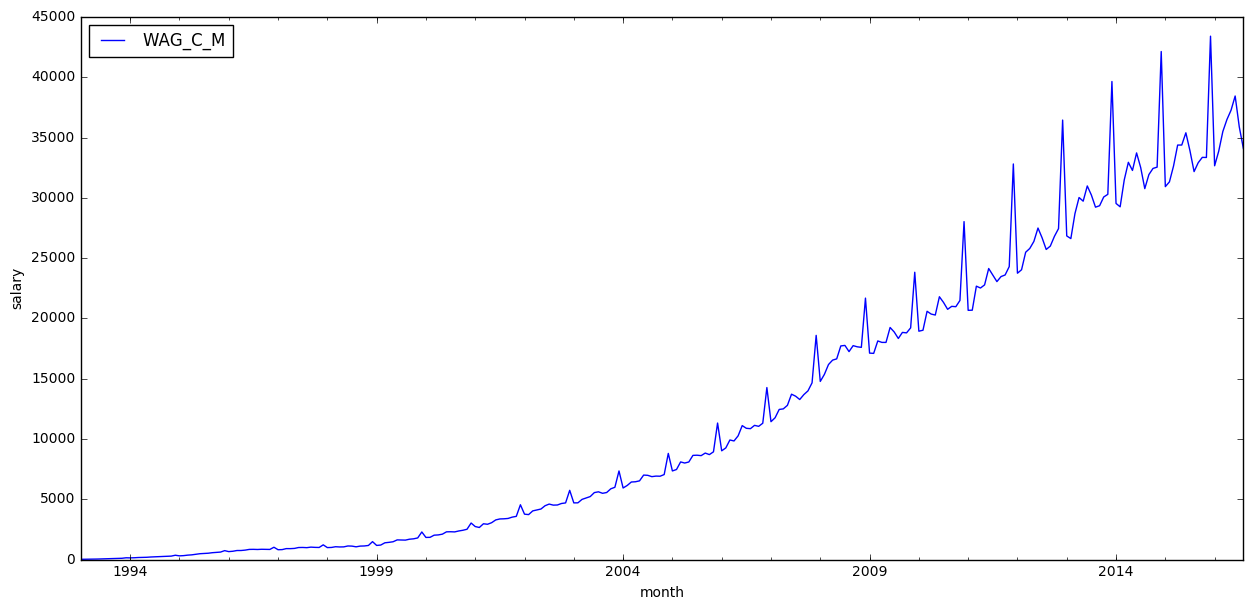

In [126]:
#посмотрим на данный временной ряд
plt.figure(figsize(15,7))
salary.plot()
plt.ylabel('salary')
pylab.show()

На построенном графике видно, что функция не стационарна: дисперсия меняется со временем, явно выражен тренд на увеличение.

Проверим ряд на стационарность формально с помощью критерия Дики-Фуллера, а также сделаем STL-декомпозицию ряда.

Критерий Дики-Фуллера: p=0.991850


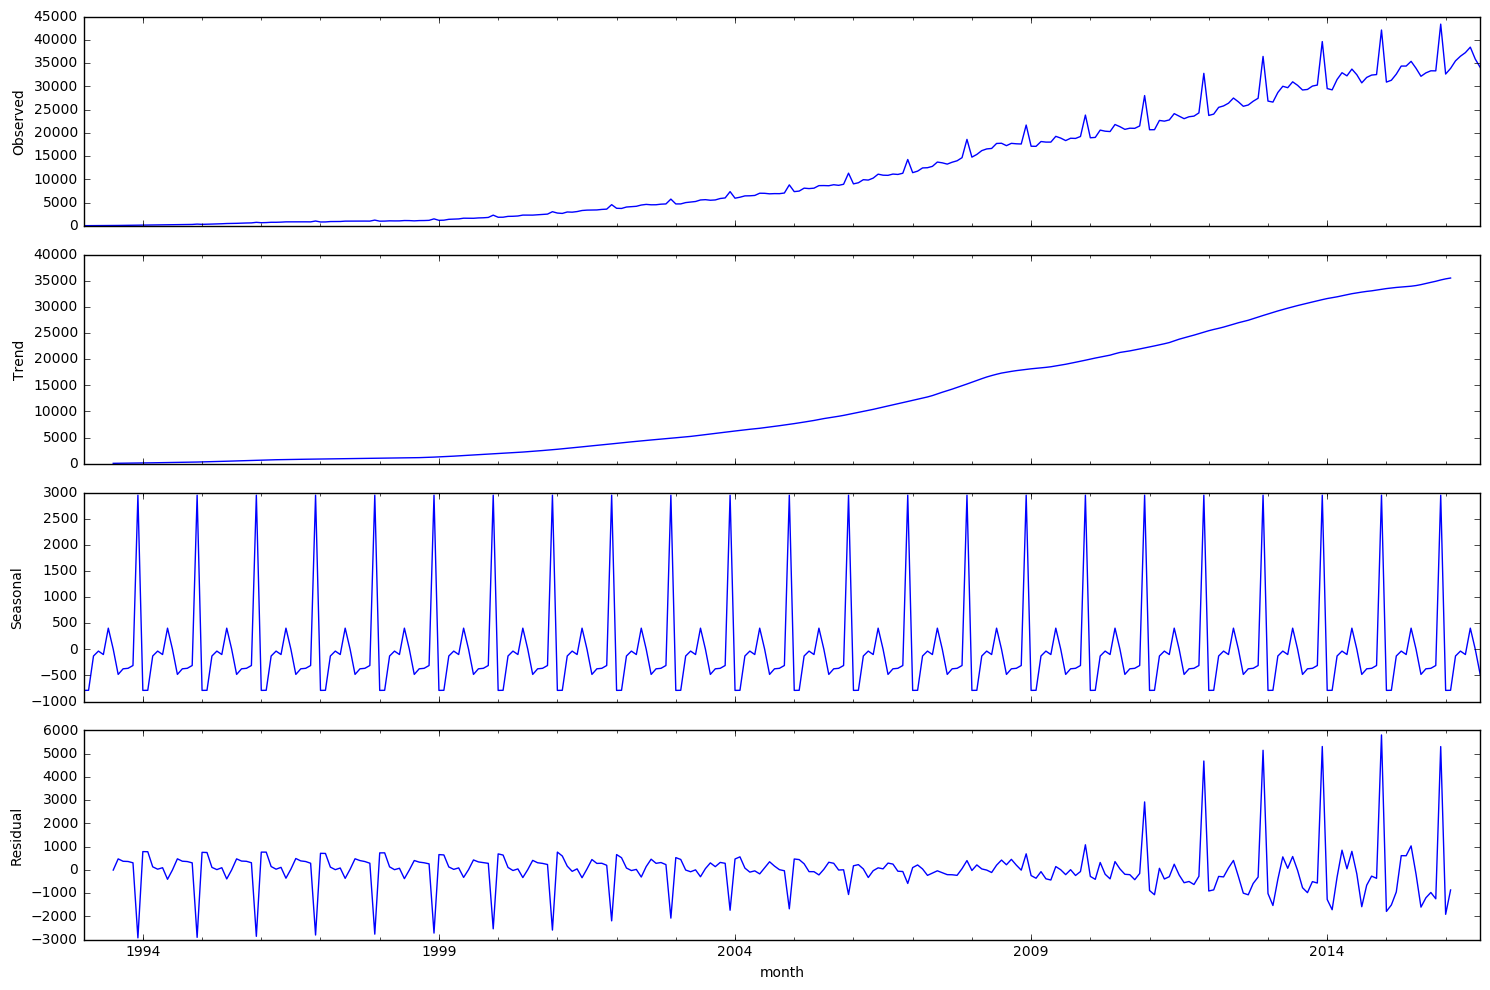

In [127]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['WAG_C_M'])[1])

Из полученных результатов видим, что критерий Дики-Фуллера не отвергает гипотезу о нестационарности ряда с большим достигаемым уровнем значимости, в ряде ярко выражен тренд и сезонность.

Проведем стабилизацию дисперсии ряда с помощью преобразования Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


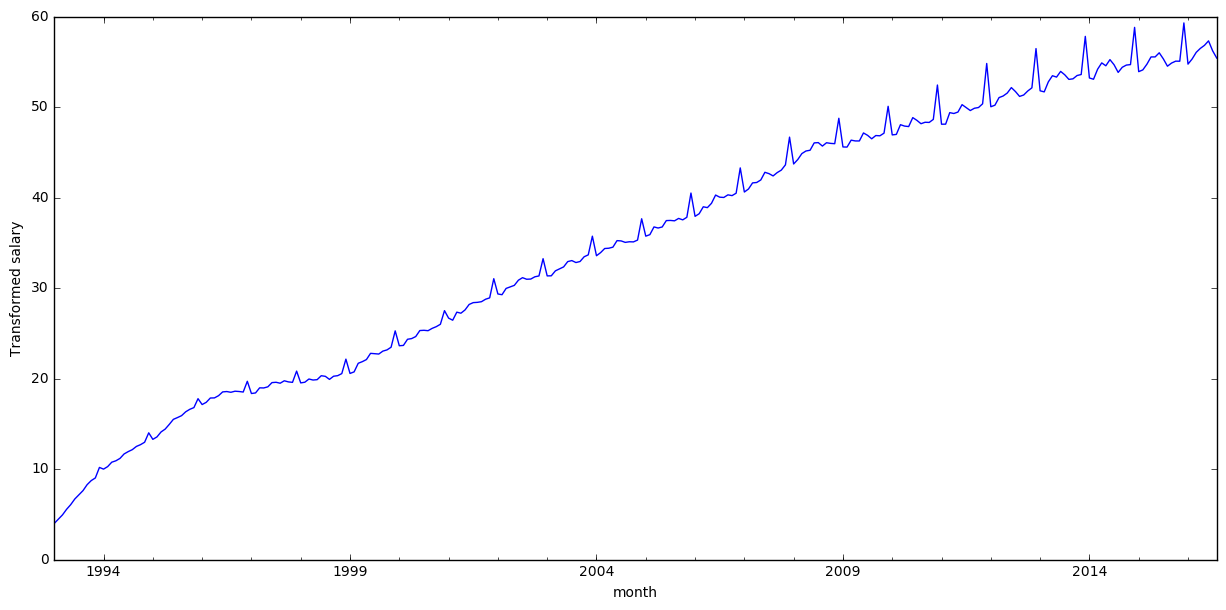

In [128]:
salary['salary_box'], lmbda = stats.boxcox(salary)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

Для того, чтобы добиться стационарности нашего ряда воспользуемся сезонным дифференциорованием

Критерий Дики-Фуллера: p=0.014697


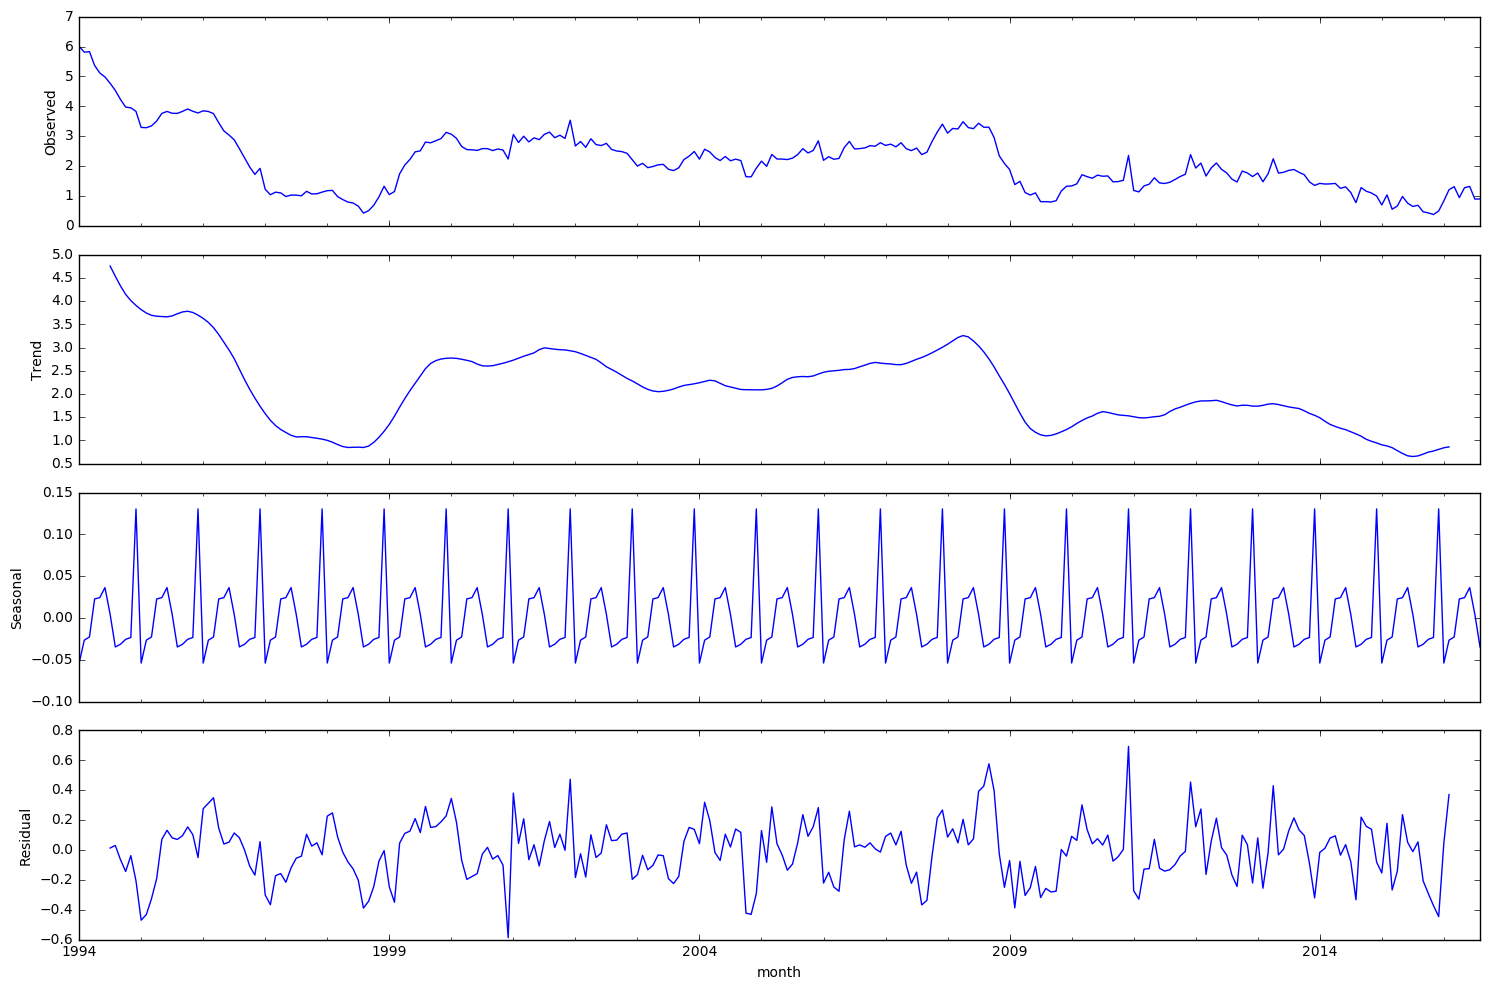

In [129]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Критерий Дики-Фуллера говорит нам о том, что ряд является стационарным, однако на графиках отчетливо видно, что тренд все равно имеет сложную структуру, а ошибки смещены относительно нуля.

Для решения проблемы проведем дифференцирование преобразованного ряда.

Критерий Дики-Фуллера: p=0.000000


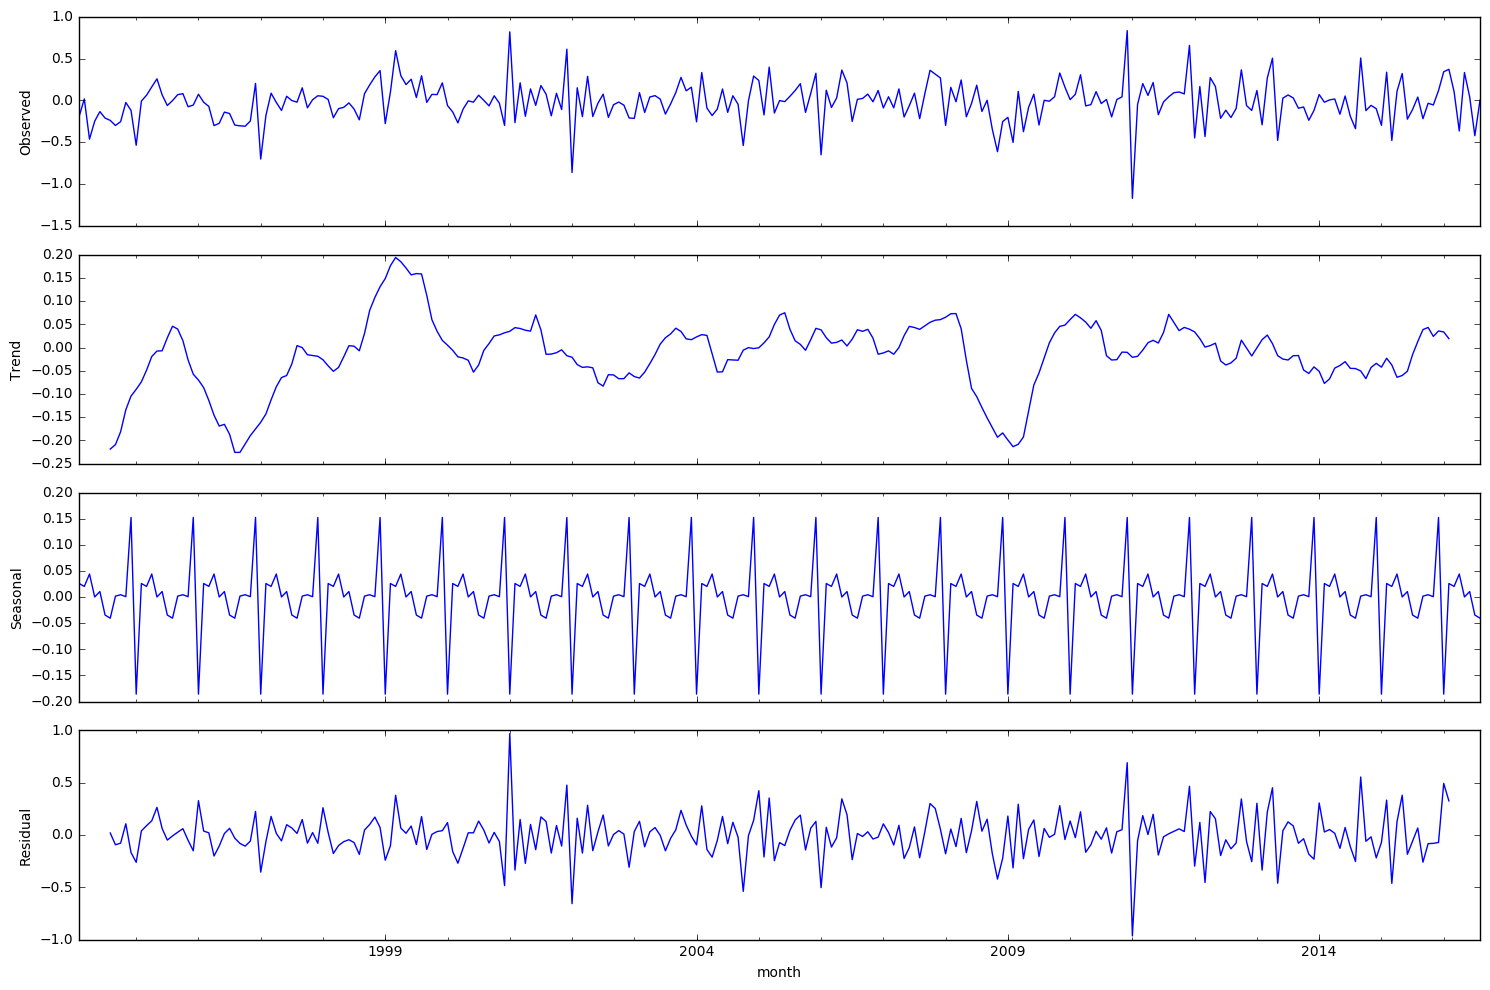

In [130]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

После последних преобразований критерий Дики-Фуллера с высокой степенью уверенности отвергает гипотезу о нестационарности ряда, на графиках видно, что ряд действительно стал стационарным.

Подбор начальных параметров для модели SARIMA произведем с помощью графиков автокорреляционной функции и частичной автокорреляционной функции.

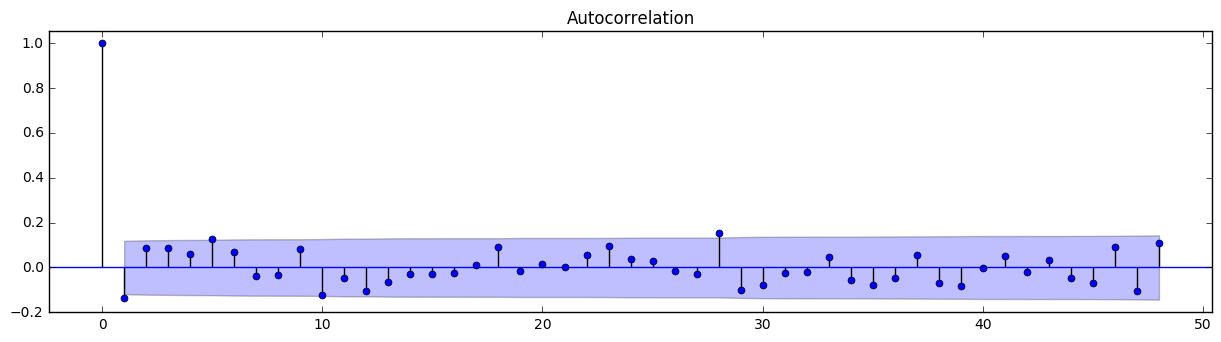

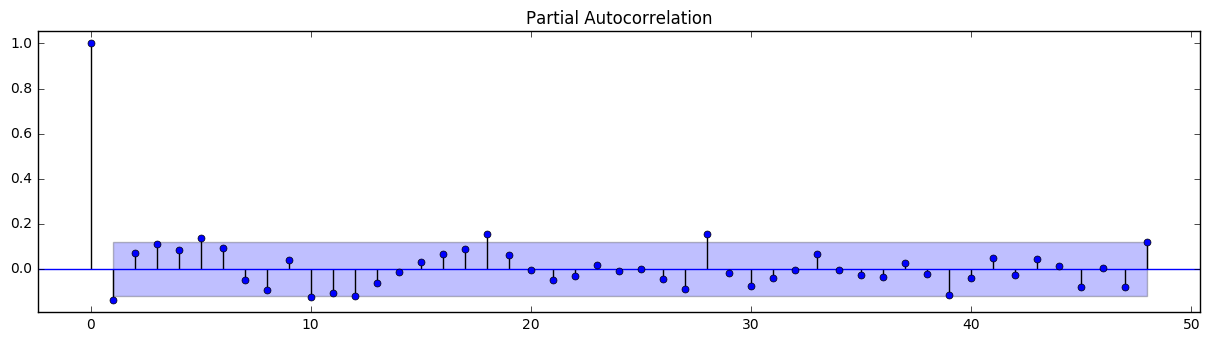

In [131]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=1, p=1

In [132]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [133]:
#Составим список из возможных комбинаций параметров
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

Проведем обучение моделей на всех комбинациях параметров, выберем лучшую используя критерий Акаике.

In [134]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
Wall time: 2.88 s


In [135]:
#Список лучших вариантов параметров согласно критерию Акаике
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
9   (1, 0, 1, 0)  0.340521
10  (1, 0, 1, 1)  0.492412
8   (1, 0, 0, 1)  0.774438
5   (0, 1, 1, 0)  1.170768
6   (0, 1, 1, 1)  1.342395


In [136]:
#Данные лучшей модели
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sun, 20 Aug 2017   AIC                              0.341
Time:                                    17:59:19   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Проведем анализ остатков, возникающих при использовании выбранной модели

Критерий Стьюдента: p=0.090794
Критерий Дики-Фуллера: p=0.000003


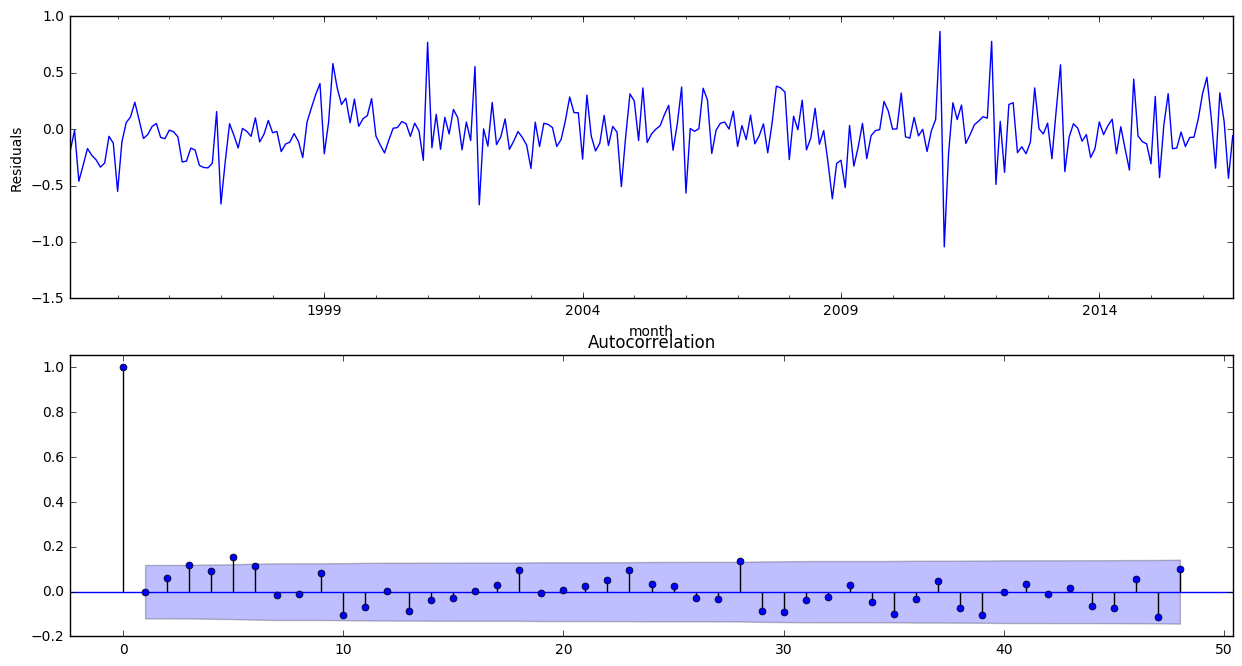

In [137]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Видим, что критерий Стьюдента гипотезу о не смещенности остатков не отвергает, а критерий Дики-Фуллера уверенно отвергает гипотезу о нестациораности ряда. Также на коррелограмме видно, что сезонность отсутствует.
Можно сделать вывод, что никакой структуру в ошибке не осталось, построенную модель можно использовать для прогнозирования.

Проверим на графике как модель описывает данные.

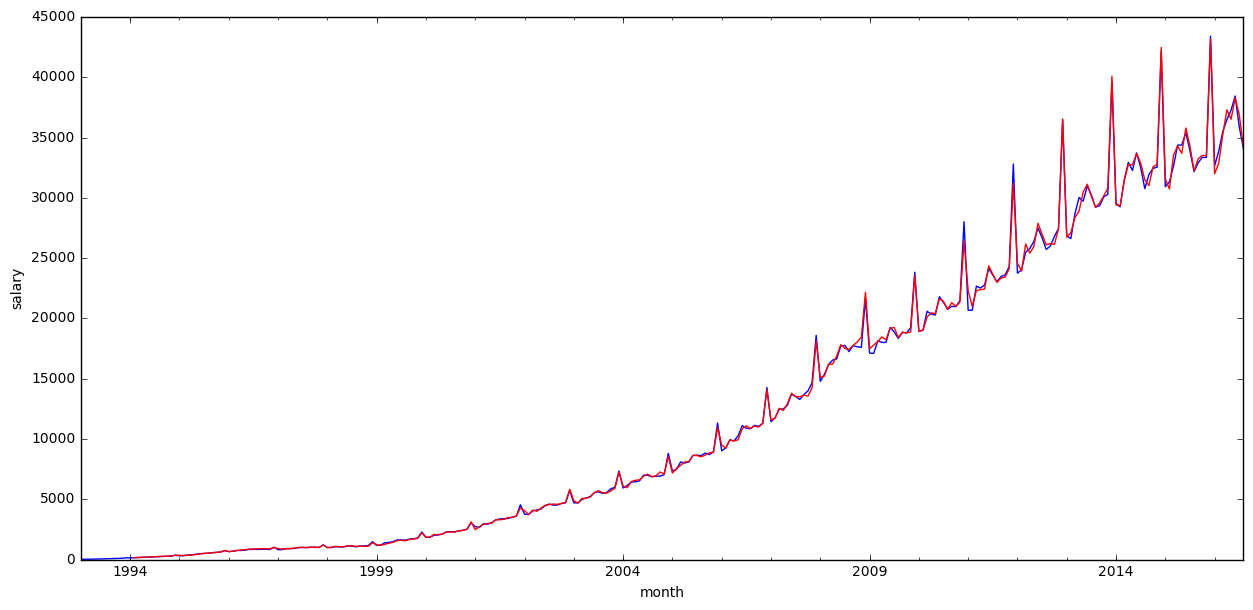

In [138]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot(color='b')
salary.model[13:].plot(color='r')
plt.ylabel('salary')
pylab.show()

Видим, модель хорошо описывает данные.

Воспользуемся полученной моделью и пострим прогноз на следующие 36 месяцев, выведем на графике.

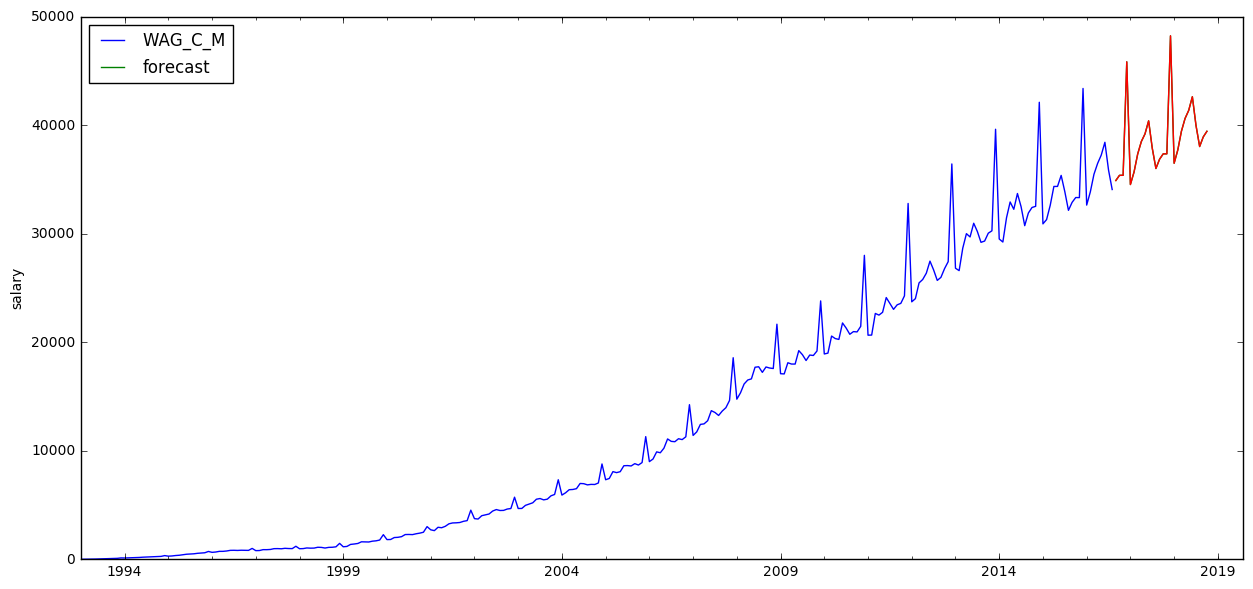

In [139]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=309), lmbda)

plt.figure(figsize(15,7))
salary2.plot()
salary2.forecast.plot(color='r')
plt.ylabel('salary')
pylab.show()